# Vision Investment Rental Worthiness Predictor.

In [84]:
import numpy as np
import sklearn 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline

In [10]:
train1 = pd.read_excel("datasets/dataset1.xlsx")
train2 = pd.read_excel("datasets/dataset2.xlsx")

In [20]:
train1.columns

Index(['Fico Score', 'Length of Employment (Months)',
       'Length of Current Residency  (Months)', 'Monthly Income',
       'Debt to Income percentage', 'Outcome'],
      dtype='object')

In [25]:
train2 = train2.drop(['Row Number '],axis=1)

In [43]:
train = pd.concat([train1,train2]).reset_index()
train.head()

,index,Fico Score,Length of Employment (Months),Length of Current Residency (Months),Monthly Income,Debt to Income percentage,Outcome
0,0,593,56,7,7920,50.313829,1.0
1,1,744,34,11,8748,24.693483,1.0
2,2,845,57,29,5582,79.617316,0.0
3,3,624,23,21,2418,81.520067,0.0
4,4,832,35,5,6637,85.491807,0.0


In [44]:
# percentage of 0s and 1s
(train.Outcome.value_counts()/750)*100

1.0    59.200000
0.0    40.666667
Name: Outcome, dtype: float64

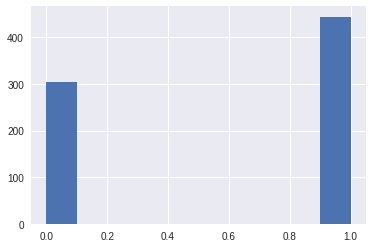

In [45]:
train.Outcome.loc[:,].hist()

In [70]:
train = train.drop(train.index[27])

In [78]:
train.isnull().sum()

index                                    0
Fico Score                               0
Length of Employment (Months)            0
Length of Current Residency  (Months)    0
Monthly Income                           0
Debt to Income percentage                0
Outcome                                  0
dtype: int64

In [99]:
# prepare values to be considered by the model.
# X includes all the features Fico Score	Length of Employment (Months)	Length of Current Residency (Months)	Monthly Income	Debt to Income percentage	
X = train.iloc[:,1:-1].values

In [100]:
# Response labels
y = train.iloc[:,6:].values

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [103]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier()

In [105]:
model_xgb.fit(X_train,y_train.ravel())

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)